In [20]:
%matplotlib inline
import seaborn
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
cities_to_states = {
    "New York": "NY",
    "San Francisco": "CA",
    "Seattle": "WA",
    "Fort Worth": "TX",
    "Charlotte": "NC",
    "Denver": "CO",
    "El Paso": "TX",
    "Los Angeles": "CA",
    "Chicago": "IL",
    "Houston": "TX",
    "Philadelphia": "PA",
    "Phoenix": "AZ",
    "San Antonio": "TX",
    "San Diego": "CA",
    "Dallas": "TX",
    "San Jose": "CA",
    "Austin": "TX",
    "Jacksonville": "FL",
    "Indianapolis": "IN",
    "Columbus": "OH",
}

In [22]:
operating_hours = pd.read_csv('top_20_operating_hours_1_21.csv', header=None, names=['Biz ID', 'City', 'Minutes Open', 'Category'])
operating_hours.head()

,Biz ID,City,Minutes Open,Category
0,FfOaddvIPj-R7eVEtBY0fw,New York,2400,984
1,FfOaddvIPj-R7eVEtBY0fw,New York,2400,769
2,25R3OiNERW0LP3hjKZg0dQ,New York,2730,856
3,25R3OiNERW0LP3hjKZg0dQ,New York,2730,794
4,9xR2VuEjIARNShAWVwNlmg,New York,2820,969


In [23]:
min_wage_substate = pd.read_csv('VZ_substate_annual.csv')[['State Abbreviation', 'City/County', 'Year', 'Annual Average']]
min_wage_substate = min_wage_substate\
    .loc[min_wage_substate['City/County'].isin(cities_to_states.keys())]
min_wage_substate.head()

,State Abbreviation,City/County,Year,Annual Average
52,IL,Chicago,2004,5.500000
53,IL,Chicago,2005,6.500000
54,IL,Chicago,2006,6.500000
55,IL,Chicago,2007,7.004110
56,IL,Chicago,2008,7.625683


In [24]:
min_wage_state = pd.read_csv('VZ_state_annual.csv')[['State Abbreviation', 'Year', 'Annual State Average', 'Annual Federal Average']]
min_wage_state.head()

,State Abbreviation,Year,Annual State Average,Annual Federal Average
0,AK,1974,2.500000,2.00
1,AK,1975,2.600000,2.10
2,AK,1976,2.800000,2.30
3,AK,1977,2.800000,2.30
4,AK,1978,3.093425,2.65


In [25]:
def highlight_sf(df, plot):
    plot.patches[df.index.get_loc('San Francisco')].set_facecolor('red')

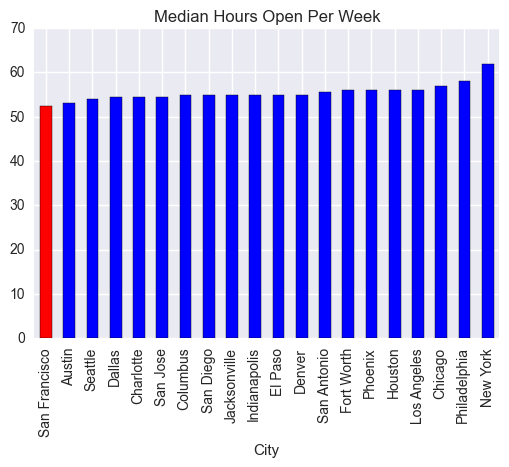

In [26]:
unique_businesses = operating_hours.drop_duplicates(subset='Biz ID')
average_hours_open_by_city = unique_businesses.groupby('City')['Minutes Open'].median().sort_values().divide(60)

plot = average_hours_open_by_city.plot(kind='bar', color='blue', title="Median Hours Open Per Week")
highlight_sf(average_hours_open_by_city, plot)
common_index = average_hours_open_by_city.index

In [27]:
average_hours_by_category_by_city = operating_hours.groupby(['Category', 'City']).median()
average_hours_by_category_by_city.head()

Minutes Open
Category City                   
766      Austin           4815.0
         Charlotte        4740.0
         Chicago          5040.0
         Columbus         4725.0
         Dallas           5040.0

In [28]:
def plot_category(category, title=None):
    df = average_hours_by_category_by_city['Minutes Open'].loc[category].sort_values().divide(60)
    ax = df.plot(kind='bar', legend=False, title=title)
    ax.set_ylabel('Median Hours Open Per Week')
    highlight_sf(df, ax)

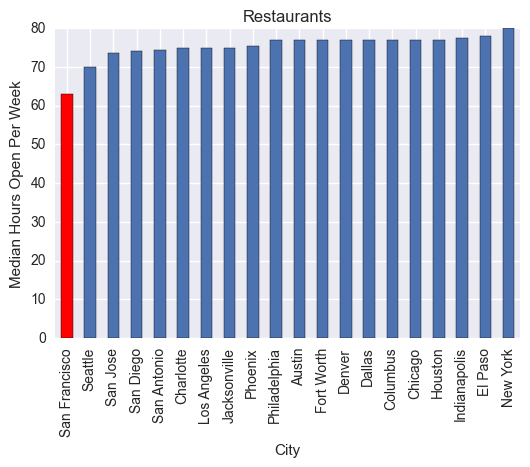

In [29]:
plot_category(822, title="Restaurants")

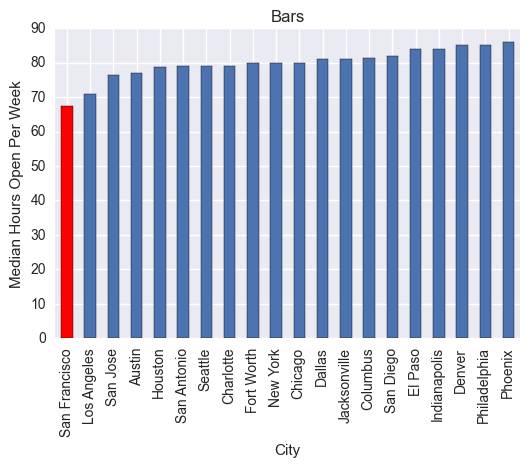

In [30]:
plot_category(825, title="Bars")

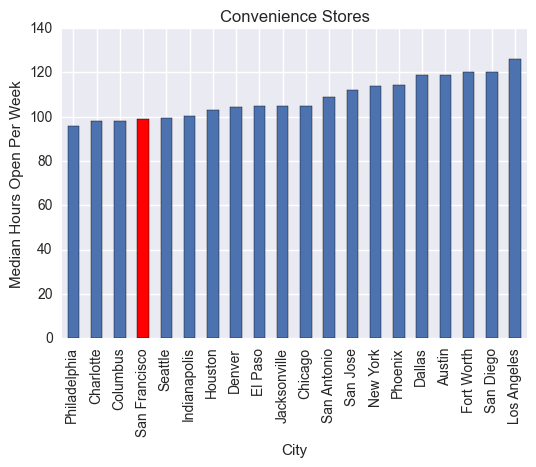

In [31]:
plot_category(813, title="Convenience Stores")

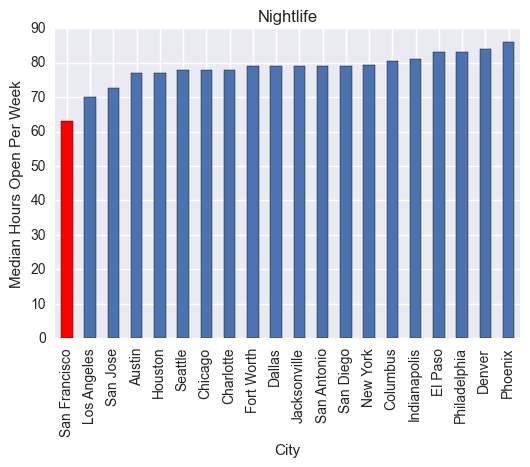

In [32]:
plot_category(953, title="Nightlife")

In [33]:
city_populations = pd.read_csv('city_populations.csv').set_index('City', drop=True).divide(1000000)
city_populations.head()

,Estimated 2015 Population
City,
New York,8.550405
Los Angeles,3.971883
Chicago,2.720546
Houston,2.296224
Philadelphia,1.567442


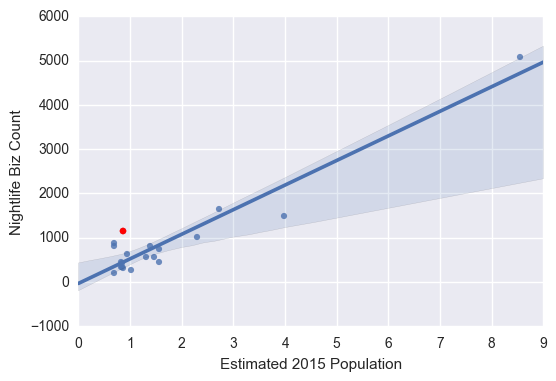

In [34]:
biz_count_by_category = operating_hours.groupby(['City', 'Category']).count()
city_populations['Nightlife Biz Count'] = biz_count_by_category['Biz ID'].unstack(level=0).loc[953]

seaborn.regplot('Estimated 2015 Population', 'Nightlife Biz Count', data=city_populations)
plt.scatter(
    city_populations['Estimated 2015 Population'].loc['San Francisco'], 
    city_populations['Nightlife Biz Count'].loc['San Francisco'],
    color='red')


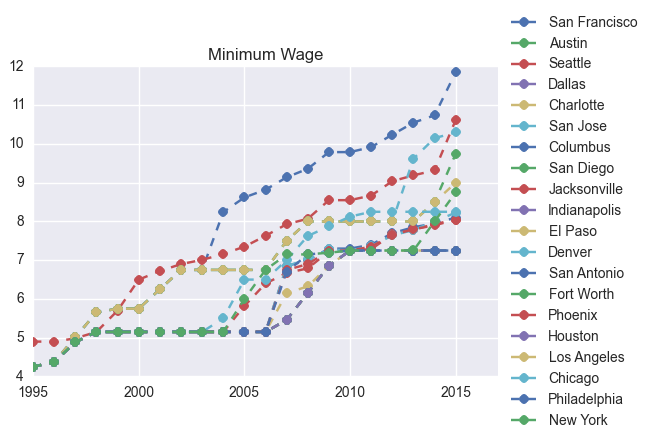

In [38]:
def get_min_wage(city, state, year):
    substate = min_wage_substate.loc[(min_wage_substate['Year'] == year) & (min_wage_substate['City/County'] == city)]
    if not substate.empty:
        return substate['Annual Average'].iloc[0]
    state = min_wage_state.loc[(min_wage_state['Year'] == year) & (min_wage_state['State Abbreviation'] == state)]
    if not state.empty:
        return state['Annual State Average'].iloc[0]
    return min_wage_state.loc[min_wage_state['Year'] == year]['Annual Federal Average']

min_wage = pd.DataFrame(columns=['City'] + [i for i in range(1995, 2016)])
for city, state in cities_to_states.iteritems():
    row = {'City': city}
    for year in range(1995, 2016):
        row.update({year: get_min_wage(city, state, year)})
    min_wage = min_wage.append(row, ignore_index=True)
min_wage = min_wage.set_index('City').reindex(index=common_index)

min_wage.transpose().plot.line(xlim=(1995, 2017), title='Minimum Wage', linestyle='--', marker='o')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))